Linear Regression 클래스
- 예측값과 실제 값의 RSS(Residual Sum of Squares)를 최소화해 OLS(Ordinary Least Squares) 추정 방식으로 구현한 클래스
- fit() 메서드로 X, y 배열을 입력받으면 회귀 계수(Coefficients)인 W를 coef_ 속성에 저장함

- 입력 파라미터
  - fit_intercept : Boolean. Intercept(절편) 값을 계산할 것인지 말지를 지정. False로 지정하면 intercept가 사용되지 않고 0으로 지정
  - normalize : fit_intercept가 False인 경우 무시. True면 회귀를 수행하기 전에 입력 데이터 세트를 정규화함
- 속성
  - coef_ : fit() 메서드를 수행했을 때 회귀 계수가 배열 형태로 저장하는 속성. Shape는 (Target 값 개수, 피처 개수)
  - intercept_ : intercept 값

선형 회귀의 다중 공선성 문제
- 입력 피처의 독립성에 많은 영향을 받음. 피처 간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 매우 민감해짐. 이런 현상을 다중 공선성(multi-collinearity) 문제라고 함
- 일반적으로 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용함

회귀 평가 지표
- MAE(Mean Absolute Error) : 실제 값과 예측값의 차이를 절대값으로 변환해 평균한 것 
$$ MAE = \frac{1}{n}\sum_{i=1}^{n}|Y_i - \check{Y}_i| $$
- MSE(Mean Squared Error) : 실제 값과 예측 값의 차이를 제곱해 평균한 것 
$$ MSE = \frac{1}{n}\sum_{i=1}^{n}(Y_i - \check{Y}_i)^2 $$
- MSLE : MSE에 로그를 적용한 것. 결정값이 클수록 오류값도 커지기 때문에 일부 큰 오류값들로 인해 전체 오류값이 커지는 것을 막아줌
$$ Log(MSE) $$
- RMSE(Root Mean Squared Error) : MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있으므로 MSE에 루트를 씌운 것
$$ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(Y_i - \check{Y}_i)^2} $$
- RMSLE : RMSE에 로그를 적용한 것. 결정값이 클수록 오류값도 커지기 때문에 일부 큰 오류값들로 인해 전체 오류값이 커지는 것을 막아줌
$$ Log(RMSE) $$ 
- $R^2$ : 분산 기반으로 예측 성능을 평가함. 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높음
$$ R^2 = \frac{예측값 Variance}{실제값 Variance} $$

sklearn 회귀 평가 API
- RMSE를 제공하지 않음. MSE에 제곱근을 씌워서 계산하는 함수를 직접 만들어야함
- MAE의 사이킷런 scoring 파라미터 값은 'neg_mean_absolute_error'. Negative(음수) 값을 가지는 의미이며, MAE는 절대값의 합이기 때문에 음수가 될 수 없음
- Scoring 함수에 'neg_mean_absolute_error'를 적용해 음수값을 반환하는 이유는 사이킷런의 Scoring 함수가 score값이 클수록 좋은 평가 결과로 자동 평가하기 때문. 따라서 -1을 원래의 평가 지표 값에 곱해서 음수(Negative)를 만들어 작은 오류 값이 더 큰 숫자로 인식하게 함. 예를 들어, 10 > 1 이지만 음수를 곱하면 -1 > -10 이 됨.
- metrics.mean_absolute_error() API는 정상적으로 양수 값을 반환함. 하지만 Scoring 함수의 scoring 파라미터 값 'neg_mean_absolute_error'의 의미는 -1 * metrics.mean_absolute_error() 임.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston

boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)
# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함.
bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 : ', bostonDF.shape)
bostonDF.head()

Boston 데이타셋 크기 :  (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- CRIM : 지역별 범죄 발생률
- ZN : 25,000 평방피트를 초과하는 거주 지역의 비율
- INDUS : 비상업 지역 넓이 비율
- CHAS : 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX : 일산화질소 농도
- RM : 거주할 수 있는 방 개수
- AGE : 1940년 이전에 건축된 소유 주택의 비율
- DIS : 5개 주요 고용센터까지의 가중 거리
- RAD : 고속도로 접근 용이도
- TAX : 10,000 달러 당 재산세율
- PTRATIO : 지역의 교사와 학생 수 비율
- B	: 지역의 흑인 거주 비율
- LSTAT : 하위 계층의 비율
-	PRICE : 본인 소유의 주택 가격(중앙값)

- 각 컬럼별로 주택가격에 미치는 영향도를 조사

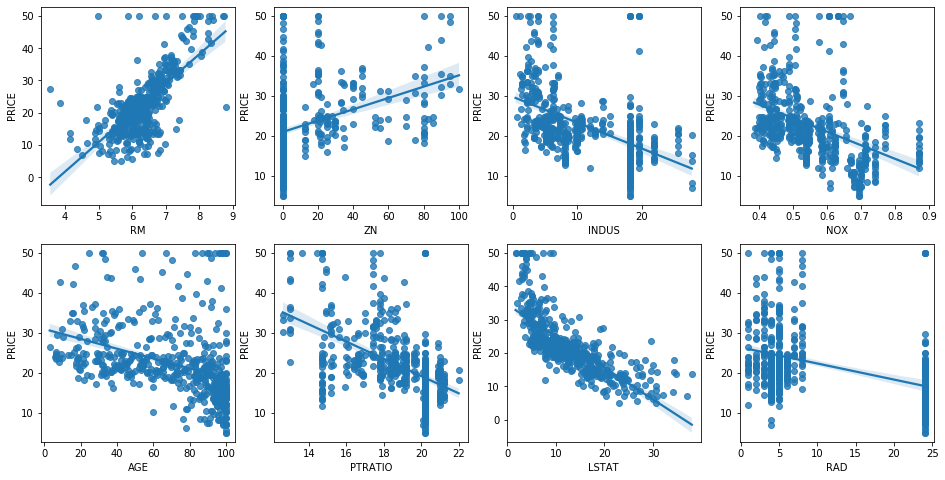

In [4]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
  row = int(i/4)
  col = i%4
  # seaborn의 regplot을 이용해 산점도와 선형 회귀 직선을 표현
  sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse) # rmse 직접 구하는 방법

print('MSE: {0:.3f}, RMSE: {1:.3F}'.format(mse, rmse))
print('Variance score:{0:.3f}'.format(r2_score(y_test, y_preds)))

MSE: 17.297, RMSE: 4.159
Variance score:0.757


In [8]:
print('절편 값:', lr.intercept_)
print('회귀 계수 값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164755
회귀 계수 값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [9]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index가 컬럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [11]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5 Fold 셋으로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 2))
print('5 folds의 평균 RMSE:{0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE:5.829
